In [6]:
import sys
sys.path.append("/home/jdli/transpec")
import torch
import numpy as np
import pandas as pd
from transGaia.transgaia import xp2label
from transGaia.inference import *
from tqdm import tqdm

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt
from matplotlib import colors

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
rcParams['font.family'] = 'sans-serif'
data_dir = "/data/jdli/gaia/"

In [21]:
data_dir = "/data/jdli/gaia/model/GXPcont_abundance/"

df = pd.read_csv(data_dir+"xp_valid.csv")
print(df.shape, df.columns)

(73856, 65) Index(['source_id', 'moh_model_cross', 'aom_model_cross', 'moh_model_self',
       'aom_model_self', 'set_id', 'APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID',
       'RA', 'DEC', 'GLON', 'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'AK_TARG', 'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV',
       'STARFLAG', 'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG',
       'VSCATTER', 'VERR', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX',
       'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR',
       'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', '

In [180]:
data_dir = "/data/jdli/gaia/"

# rdf = pd.read_csv(data_dir + "APtransXP_1209_4lbs_55coefs.csv")
rdf = pd.read_csv(data_dir + "APtransXP_1215_4lbs_55coefs.csv")
print(rdf.shape)

(66701, 58)


In [181]:
rdf = rdf.merge(df[['source_id', 'tmass_id']], on='source_id')
print(rdf.shape)

(60036, 59)


In [17]:
from astropy.io import ascii

gctable =  ascii.read("ftp://cdsarc.u-strasbg.fr/ftp/J/A+A/622/A191/table2.dat",
                   readme="ftp://cdsarc.u-strasbg.fr/ftp/J/A+A/622/A191/ReadMe")

df_gcraw = gctable.to_pandas()

print(df_gcraw.shape, df_gcraw.columns)

(885, 48) Index(['---', '2MASS', 'Cluster', 'Evol', 'Teff', 'logg', '[Fe/H]', 'e_[Fe/H]',
       'l_[C/Fe]', '[C/Fe]', 'e_[C/Fe]', 'o_[C/Fe]', 'l_[N/Fe]', '[N/Fe]',
       'e_[N/Fe]', 'o_[N/Fe]', 'l_[O/Fe]', '[O/Fe]', 'e_[O/Fe]', 'o_[O/Fe]',
       'l_[Mg/Fe]', '[Mg/Fe]', 'e_[Mg/Fe]', 'o_[Mg/Fe]', 'l_[Al/Fe]',
       '[Al/Fe]', 'e_[Al/Fe]', 'o_[Al/Fe]', 'l_[Si/Fe]', '[Si/Fe]',
       'e_[Si/Fe]', 'o_[Si/Fe]', 'l_[K/Fe]', '[K/Fe]', 'e_[K/Fe]', 'o_[K/Fe]',
       'l_[Ca/Fe]', '[Ca/Fe]', 'e_[Ca/Fe]', 'o_[Ca/Fe]', 'l_[Ce/Fe]',
       '[Ce/Fe]', 'e_[Ce/Fe]', 'o_[Ce/Fe]', 'l_[Nd/Fe]', '[Nd/Fe]',
       'e_[Nd/Fe]', 'o_[Nd/Fe]'],
      dtype='object')


In [32]:

df_gcraw = df_gcraw.assign(tmass_id=df_gcraw['---']+df_gcraw['2MASS'])
df_gcraw.head()


,---,2MASS,Cluster,Evol,Teff,logg,[Fe/H],e_[Fe/H],l_[C/Fe],[C/Fe],...,o_[Ca/Fe],l_[Ce/Fe],[Ce/Fe],e_[Ce/Fe],o_[Ce/Fe],l_[Nd/Fe],[Nd/Fe],e_[Nd/Fe],o_[Nd/Fe],tmass_id
0,2M,17162228+4258036,M92,RGB,4978,1.84,NaN,NaN,NaN,NaN,...,1,<,1.928,NaN,1,NaN,NaN,NaN,0,2M17162228+4258036
1,2M,17163577+4256392,M92,RGB,5051,2.03,-2.199,0.254,<,1.684,...,1,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2M17163577+4256392
2,2M,17163748+4306155,M92,RGB,4389,0.42,-2.130,0.132,NaN,-0.364,...,1,NaN,-0.258,0.058,3,NaN,NaN,NaN,0,2M17163748+4306155
3,2M,17164330+4304161,M92,RGB,4949,1.76,-2.191,0.032,<,1.230,...,1,<,2.022,NaN,1,NaN,NaN,NaN,0,2M17164330+4304161
4,2M,17164395+4307318,M92,RGB,4913,1.67,-2.235,0.235,<,0.950,...,1,NaN,NaN,NaN,0,NaN,NaN,NaN,0,2M17164395+4307318


In [182]:
df_gc = df_gcraw.merge(rdf, on='tmass_id')
print(df_gc.shape, df_gc.columns)

(102, 107) Index(['---', '2MASS', 'Cluster', 'Evol', 'Teff', 'logg', '[Fe/H]', 'e_[Fe/H]',
       'l_[C/Fe]', '[C/Fe]',
       ...
       'snr_bp', 'snr_bp10', 'snr_bp55', 'snr_rp', 'snr_rp10', 'snr_rp55',
       'teff_bin', 'logg_bin', 'TEFF_bin', 'M_H_bin'],
      dtype='object', length=107)


In [183]:

gc_grouped = df_gc.groupby('Cluster')

gc_grouped = gc_grouped.filter(lambda x: len(x) > 5)



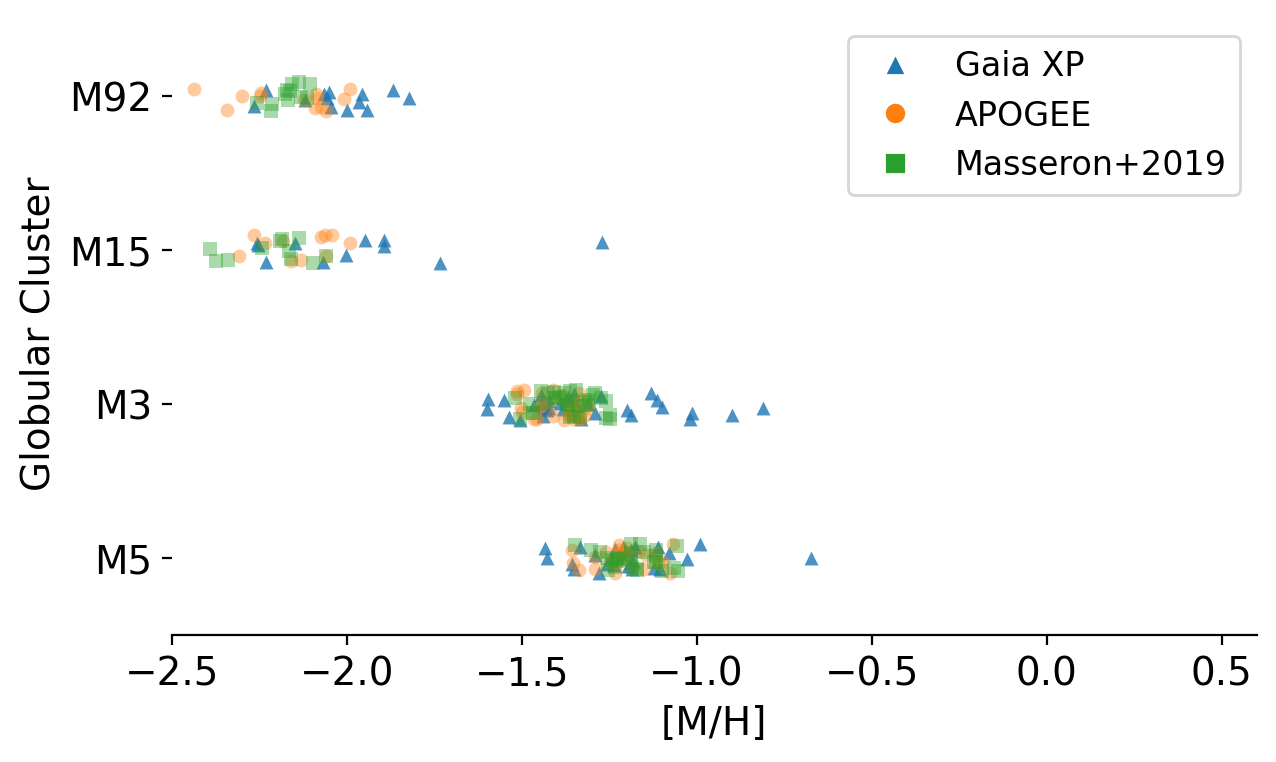

In [184]:
# Initialize the figure
from matplotlib.lines import Line2D
import seaborn as sns

f, ax = plt.subplots(1,1,figsize=(7,4))
sns.despine(left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=gc_grouped, x="moh_cross", y="Cluster", 
    marker='^',
    dodge=True, alpha=.8, zorder=1, legend=False,
    ax=ax
)

sns.stripplot(
    data=gc_grouped, x="M_H", y="Cluster", marker='o',
    dodge=True, alpha=.4, zorder=1, legend=False
)

sns.stripplot(
    data=gc_grouped, x="[Fe/H]", y="Cluster", marker='s',
    dodge=True, alpha=.4, zorder=1, legend=False
)

legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Gaia XP', markerfacecolor='#1f77b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='APOGEE', markerfacecolor='#ff7f0e', markersize=8),
    Line2D([0], [0], marker='s', color='w', label='Masseron+2019', markerfacecolor='#2ca02c', markersize=8),
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
ax.set_xlim([-2.5, 0.6]);
ax.set_xlabel("[M/H]");
ax.set_ylabel("Globular Cluster ");

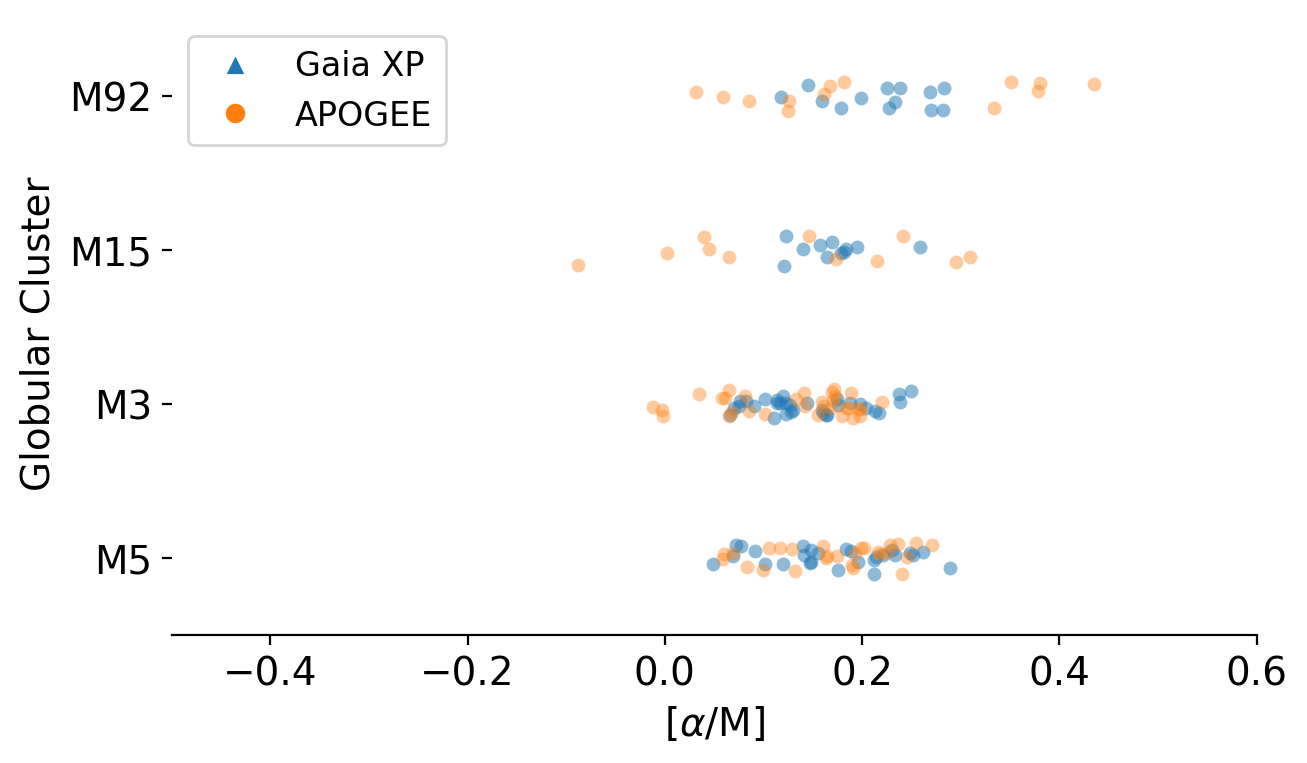

In [185]:
f, ax = plt.subplots(1,1,figsize=(7,4))
sns.despine(left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=gc_grouped, x="aom_cross", y="Cluster", 
    # hue="species",
    dodge=True, alpha=.5, zorder=1, legend=False,
    ax=ax
)

sns.stripplot(
    data=gc_grouped, x="ALPHA_M", y="Cluster", 
    dodge=True, alpha=.4, zorder=1, legend=False
)


legend_elements = [
    Line2D([0],[0], marker='^', color='w', label='Gaia XP', markerfacecolor='#1f77b4', markersize=8),
    Line2D([0],[0], marker='o', color='w', label='APOGEE', markerfacecolor='#ff7f0e', markersize=8)
]

ax.legend(handles=legend_elements, loc='upper left', fontsize=12)
ax.set_xlim([-0.5, 0.6]);
ax.set_xlabel(r"[$\alpha$/M]");
ax.set_ylabel("Globular Cluster ");

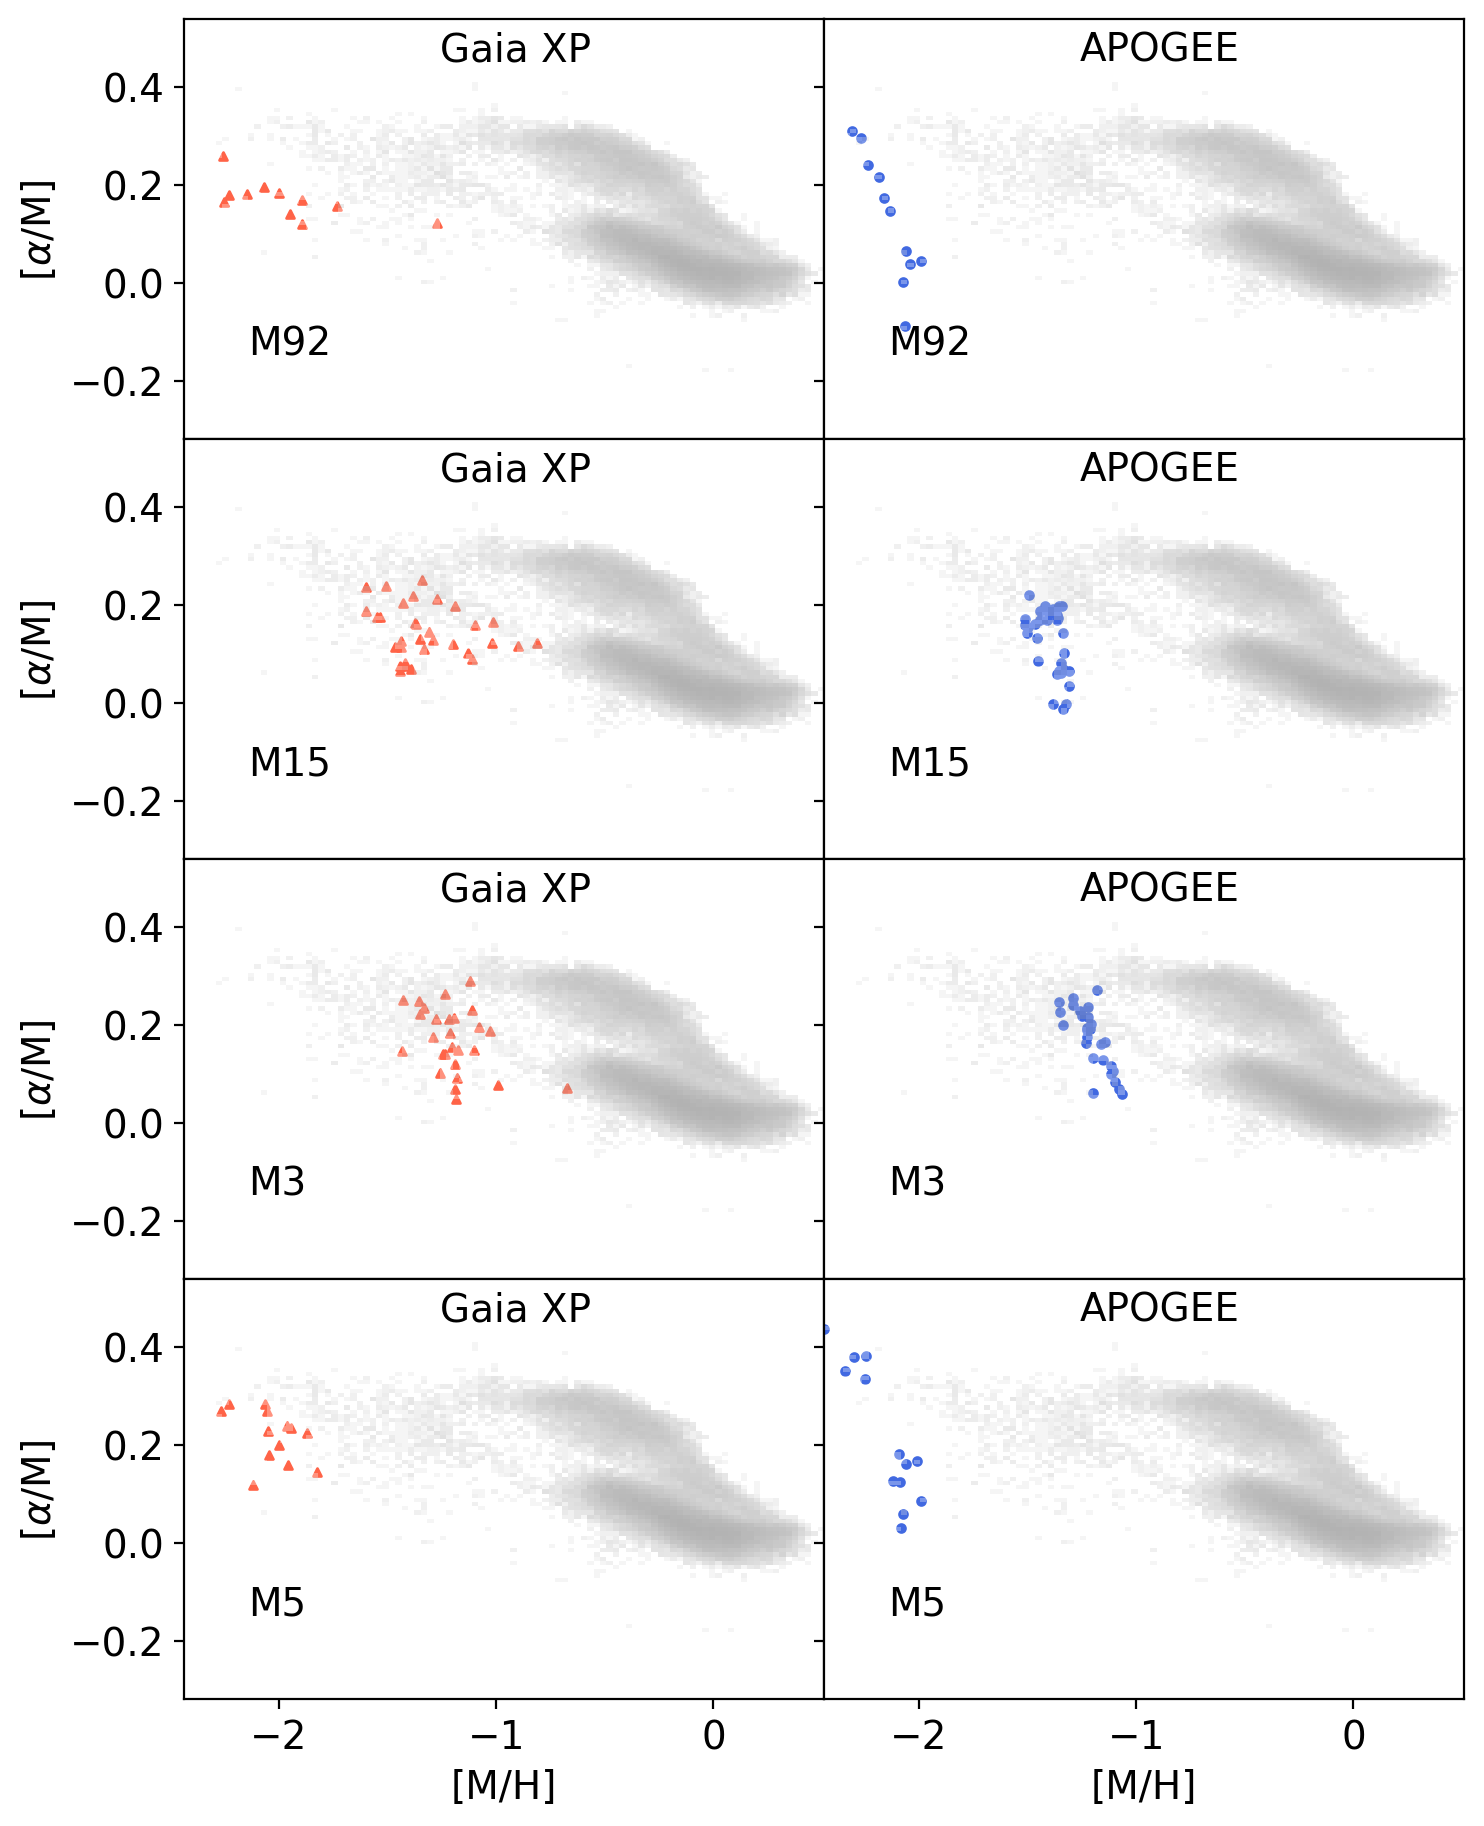

In [373]:
moh_range = [-2.5, 0.5]
aom_range = [-0.15, 0.45]

cluster_names = gc_grouped['Cluster'].unique()

# aom_moh_diag = plt.imread("../fig/alpha_dia_bkg.png")

fig, axs = plt.subplots(4,2, figsize=(8, 10), sharey=True, sharex=True)

for i, (gn,cluster) in enumerate(gc_grouped.groupby('Cluster')):

    ax1, ax2 = axs[i,:]
    ax1.scatter(cluster['moh_cross'], cluster['aom_cross'],
                s=8, c='tomato', marker='^')
    ax1.set_xlim(moh_range)
    ax1.set_ylim(aom_range)
    ax1.hist2d(rdf['M_H'], rdf['ALPHA_M'], bins=100, alpha=0.3,
           cmap='binary', norm=colors.LogNorm())
    ax1.text(0.1, 0.2, cluster_names[i], 
            transform=ax1.transAxes, zorder=3)
    ax1.text(0.4, 0.9, 'Gaia XP',
            transform=ax1.transAxes, zorder=3)
    ax1.set_xlabel('[M/H]'); ax1.set_ylabel(r'[$\alpha$/M]');
    
    ax2.scatter(cluster['M_H'], cluster['ALPHA_M'], 
                s=8, c='royalblue', marker='o')
    ax2.set_xlim(moh_range)
    ax2.set_ylim(aom_range)
    ax2.hist2d(rdf['M_H'], rdf['ALPHA_M'], bins=100, alpha=0.3,
           cmap='binary', norm=colors.LogNorm())
    ax2.text(0.1, 0.2, cluster_names[i],
            transform=ax2.transAxes, zorder=3)
    ax2.text(0.4, 0.9, 'APOGEE',
            transform=ax2.transAxes, zorder=3)
    ax2.set_xlabel('[M/H]'); 
    # ax2.set_ylabel(r'[$\alpha$/M]');

# plt.tight_layout()
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.99, wspace=0, hspace=0)
fig.savefig("../fig/gc_valid.pdf")

# Omega Cen

In [41]:
from astropy.table import Table
omegacen = Table.read("../docs/data/omegacen.fits").to_pandas()

print(omegacen.shape, omegacen.columns)

(180, 178) Index(['ID_1', 'RAdeg', 'DEdeg', 'Bmag', 'Vmag', 'Imag', 'Ksmag', 'RV', 'e_RV',
       'ID_2',
       ...
       'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X',
       'MeasureJD', 'angDist_x'],
      dtype='object', length=178)


In [42]:
from astroquery.gaia import Gaia
Gaia.login()

#jli06
#zwHD5BFFcbT@HZW

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  jli06
Password:  ········


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [45]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]
        
        
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = omegacen['Source']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')

* Input list contains 180 source_IDs
* This list is split into 1 chunks of <= 5000 elements each


In [46]:
retrieval_type = 'XP_CONTINUOUS'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3' # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'

datalink_all = []

# dl_keys  = [inp for inp in datalink.keys()]
# dl_keys.sort()

ii = 0
for chunk in ids_chunks:
    ii+=1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk,
                               data_release = data_release, 
                               retrieval_type=retrieval_type, format='votable',
                               data_structure=data_structure)
    
    datalink_all.append(datalink)

In [52]:
from tqdm import tqdm
import joblib

scaler_bp = joblib.load('../docs/models/scaler_bp.gz')
scaler_rp = joblib.load('../docs/models/scaler_rp.gz')

product_list_tb  = [item for sublist in datalink_all for item in sublist[dl_key]]
# product_list_ids = [item.get_field_by_id("source_id") for sublist in datalink_all for item in sublist[dl_key]]
product_list_ids = [sid for sublist in datalink_all for item in sublist[dl_key] for sid in item.array["source_id"].data]


N_COEFF = 55
bp_coef = []
rp_coef = []

i = 0
for kk,tab in tqdm(enumerate(product_list_tb)):
    
    bp_coefficients         = np.array([d.data for d in tab.array["bp_coefficients"]]).reshape(-1, N_COEFF)
    bp_coefficients_errors  = np.array([d.data for d in tab.array["bp_coefficient_errors"]]).reshape(-1, N_COEFF)


    rp_coefficients         = np.array([d.data for d in tab.array["rp_coefficients"]]).reshape(-1, N_COEFF)
    rp_coefficients_errors  = np.array([d.data for d in tab.array["rp_coefficient_errors"]]).reshape(-1, N_COEFF)
    
    bp_coef.append(bp_coefficients)
    rp_coef.append(rp_coefficients)
    
bp_coef = np.vstack(tuple([_ for _ in bp_coef]))
rp_coef = np.vstack(tuple([_ for _ in rp_coef]))

norm_bp_coef = scaler_bp.transform(np.log10(bp_coef+6*1e4))
norm_rp_coef = scaler_rp.transform(np.log10(rp_coef+6*1e4))

print(bp_coef.shape, rp_coef.shape)
print(len(product_list_ids))


xp = {'norm_bp_coef':norm_bp_coef, 'norm_rp_coef':norm_rp_coef, 
         'source_id':product_list_ids}

gcdf_xp = pd.DataFrame(xp)
np.save(data_dir+"GC_Mucciarelli.npy", xp)

1it [00:00, 385.68it/s]

(113, 55) (113, 55)
113


In [84]:
gc_input = np.concatenate((np.concatenate(gcdf_xp['norm_bp_coef'].values, axis=0).reshape(-1,55),
                           np.concatenate(gcdf_xp['norm_rp_coef'].values, axis=0).reshape(-1,55),
                      gcdf_xp[['Jmag','Hmag','Kmag']].values/99.), axis=1)
print(gc_input.shape)

(113, 113)


In [68]:
xp = {'norm_bp_coef':list(norm_bp_coef), 'norm_rp_coef':list(norm_rp_coef), 
         'source_id':product_list_ids}

gcdf_xp = pd.DataFrame(xp)

gcdf_xp = gcdf_xp.merge(omegacen, left_on='source_id', right_on='Source')
print(gcdf_xp.shape, gcdf_xp.columns)

(113, 181) Index(['norm_bp_coef', 'norm_rp_coef', 'source_id', 'ID_1', 'RAdeg', 'DEdeg',
       'Bmag', 'Vmag', 'Imag', 'Ksmag',
       ...
       'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X',
       'MeasureJD', 'angDist_x'],
      dtype='object', length=181)


In [54]:
import sys
sys.path.append("/home/jdli/transpec")

import torch
from transGaia.transgaia import xp2label
from transGaia.data import GXP_5lb

In [56]:
device = torch.device('cuda:0')

BATCH_SIZE = 512

model = xp2label(
    n_encoder_inputs=113, n_outputs=4,
    channels=128, n_heads=8, n_layers=8).to(device)


model_name = "/data/jdli/gaia/model/1214_4l/sp2_4l_robustnorm_mse_0_ep200.pt"
model.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [88]:
with torch.no_grad():

    lbs_raw = model(torch.tensor(gc_input.astype(np.float32)).to(device))

In [90]:
from transGaia.inference import *


preds = recover_labels(lbs_raw.cpu().numpy())

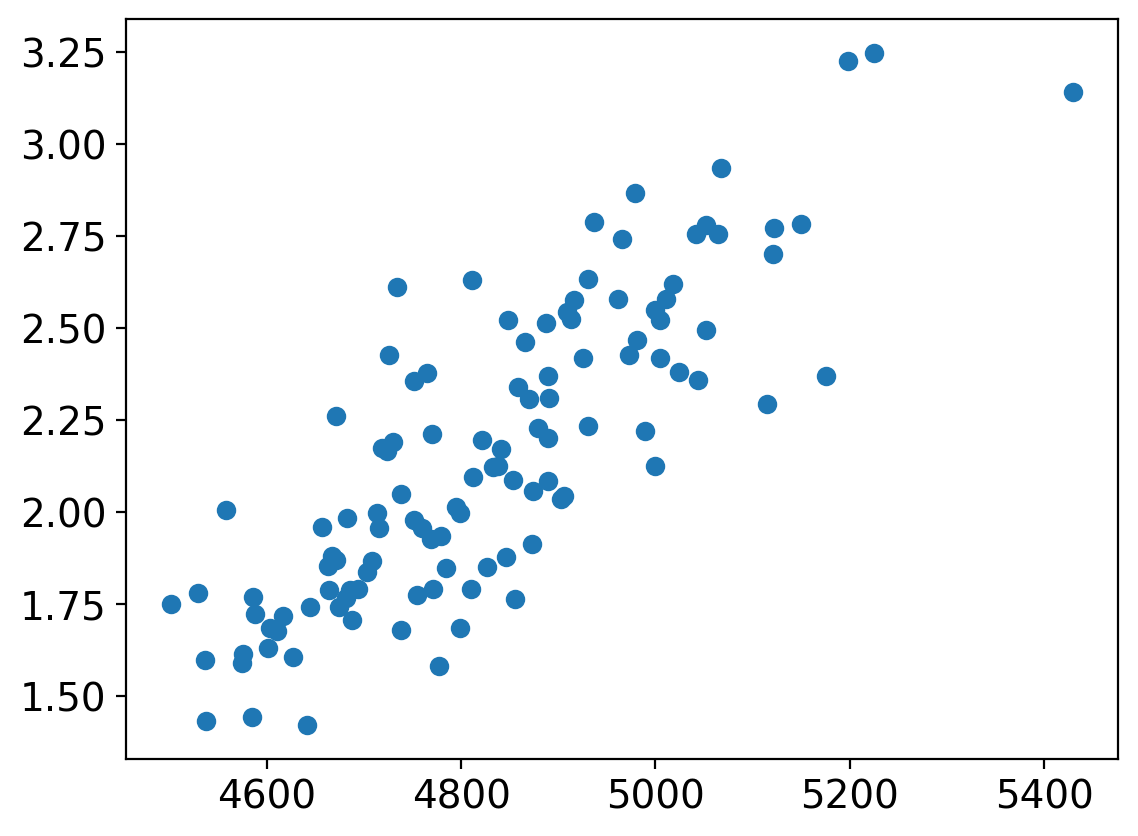

In [372]:
plt.scatter(preds[:,0], preds[:,1])

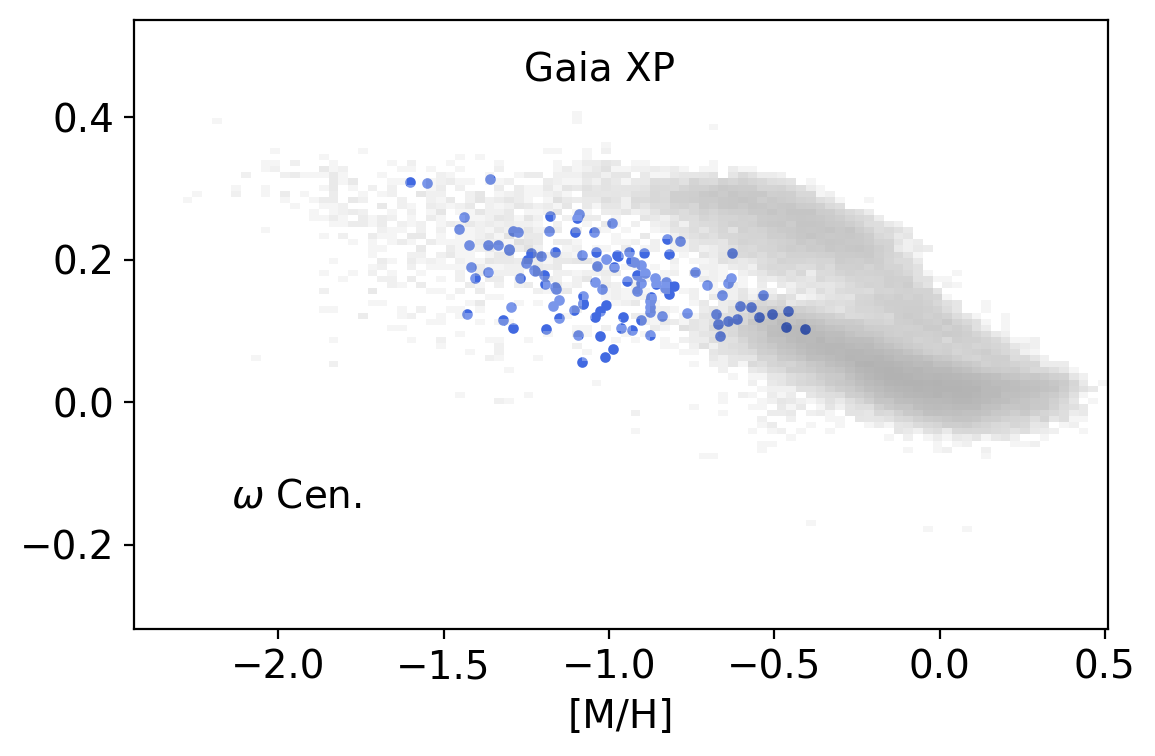

In [379]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(preds[:,2], preds[:,3], 
            s=8, c='royalblue', marker='o')
ax.set_xlim(moh_range)
ax.set_ylim(aom_range)
ax.hist2d(rdf['M_H'], rdf['ALPHA_M'], bins=100, alpha=0.3,
       cmap='binary', norm=colors.LogNorm())
ax.text(0.1, 0.2, r"$\omega$ Cen.",
        transform=ax.transAxes, zorder=3)
ax.text(0.4, 0.9, 'Gaia XP',
        transform=ax.transAxes, zorder=3)
ax.set_xlabel('[M/H]');
plt.tight_layout()
fig.savefig("../fig/omegacen.pdf")

# Open cluster

In [278]:
xtfu = pd.read_csv("xtfu22_v2.csv")
print(xtfu.shape, xtfu.columns)

(1434, 213) Index(['RAdeg_1', 'DEdeg_1', 'Teff_1', 'e_Teff', 'logg_1', 'e_logg', 'feh_lm',
       'e_feh_lm', 'RV_1', 'e_RV_1',
       ...
       'teff_err', 'logg_2', 'logg_err', 'feh', 'feh_err', 'rv_2', 'rv_err',
       'alpha_m', 'alpha_m_err', 'Separation'],
      dtype='object', length=213)


In [146]:
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = xtfu['Source']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')

* Input list contains 7479 source_IDs
* This list is split into 2 chunks of <= 5000 elements each


In [147]:
retrieval_type = 'XP_CONTINUOUS'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3' # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'

datalink_all = []

# dl_keys  = [inp for inp in datalink.keys()]
# dl_keys.sort()

ii = 0
for chunk in ids_chunks:
    ii+=1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk,
                               data_release = data_release, 
                               retrieval_type=retrieval_type, format='votable',
                               data_structure=data_structure)
    
    datalink_all.append(datalink)

In [149]:
product_list_tb  = [item for sublist in datalink_all for item in sublist[dl_key]]
product_list_ids = [sid for sublist in datalink_all for item in sublist[dl_key] for sid in item.array["source_id"].data]

N_COEFF = 55
bp_coef = []
rp_coef = []

i = 0
for kk,tab in tqdm(enumerate(product_list_tb)):
    
    bp_coefficients         = np.array([d.data for d in tab.array["bp_coefficients"]]).reshape(-1, N_COEFF)
    bp_coefficients_errors  = np.array([d.data for d in tab.array["bp_coefficient_errors"]]).reshape(-1, N_COEFF)

    rp_coefficients         = np.array([d.data for d in tab.array["rp_coefficients"]]).reshape(-1, N_COEFF)
    rp_coefficients_errors  = np.array([d.data for d in tab.array["rp_coefficient_errors"]]).reshape(-1, N_COEFF)
    
    bp_coef.append(bp_coefficients)
    rp_coef.append(rp_coefficients)
    
bp_coef = np.vstack(tuple([_ for _ in bp_coef]))
rp_coef = np.vstack(tuple([_ for _ in rp_coef]))

norm_bp_coef = scaler_bp.transform(np.log10(bp_coef+6*1e4))
norm_rp_coef = scaler_rp.transform(np.log10(rp_coef+6*1e4))

print(bp_coef.shape, rp_coef.shape)
print(len(product_list_ids))


xp = {'norm_bp_coef':norm_bp_coef, 'norm_rp_coef':norm_rp_coef, 'source_id':product_list_ids}

# ocdf_xp = pd.DataFrame(xp)
np.save(data_dir+"OC_xtfu.npy", xp)

2it [00:00, 41.56it/s]

(3831, 55) (3831, 55)
3831



/tmp/ipykernel_31883/1584217796.py:23: RuntimeWarning: invalid value encountered in log10
  norm_bp_coef = scaler_bp.transform(np.log10(bp_coef+6*1e4))


In [279]:
ocdf_xp = pd.DataFrame({'norm_bp_coef':list(norm_bp_coef), 
                        'norm_rp_coef':list(norm_rp_coef), 
                        'source_id':product_list_ids})
print(ocdf_xp.shape)

ocdf_xp = pd.merge(ocdf_xp, xtfu, left_on='source_id', right_on='Source', how='left')
print(ocdf_xp.shape, ocdf_xp.columns)

(3831, 3)
(4012, 216) Index(['norm_bp_coef', 'norm_rp_coef', 'source_id', 'RAdeg_1', 'DEdeg_1',
       'Teff_1', 'e_Teff', 'logg_1', 'e_logg', 'feh_lm',
       ...
       'teff_err', 'logg_2', 'logg_err', 'feh', 'feh_err', 'rv_2', 'rv_err',
       'alpha_m', 'alpha_m_err', 'Separation'],
      dtype='object', length=216)


In [214]:
oc_input = np.concatenate((np.concatenate(ocdf_xp['norm_bp_coef'].values, axis=0).reshape(-1,55),
                           np.concatenate(ocdf_xp['norm_rp_coef'].values, axis=0).reshape(-1,55),
                      ocdf_xp[['Jmag','Hmag','Kmag']].values/99.), axis=1)
print(oc_input.shape)



(6988, 113)


In [215]:
from transGaia.inference import *

model_name = "/data/jdli/gaia/model/1214_4l/sp2_4l_robustnorm_mse_0_ep200.pt"

lbs_oc = infer_4lbs_model(model_name, oc_input, device=device)

In [280]:
oc_xp_pred = pd.DataFrame(
    lbs_oc['labels'],
    columns=['teff_cross', 'logg_cross', 'moh_cross', 'aom_cross']
)

oc_xp_pred.columns

oc_xp_pred = pd.concat((ocdf_xp, oc_xp_pred), axis=1)


In [281]:
# oc_xp_pred.head()

oc_xp_pred = oc_xp_pred.drop_duplicates(subset=['source_id'])
print(oc_xp_pred.shape)

(3818, 220)


# OCCAM

In [350]:
octable = Table.read(data_dir+"occam_member-DR17.fits")

df_ocraw = octable.to_pandas()
print(df_ocraw.shape, df_ocraw.columns)

df_ocraw = df_ocraw.assign(tmass_id=[i.decode('utf-8') for i in df_ocraw['APOGEE_ID'].values], 
                           CLUSTER=[i.decode('utf-8') for i in df_ocraw['CLUSTER'].values])

df_ocraw = df_ocraw[df_ocraw['FEH_PROB']>0.8]
df_oc = pd.merge(rdf, df_ocraw, on="tmass_id", )
print(df_oc.shape)

(26699, 17) Index(['CLUSTER', 'APOGEE_ID', 'LOCATION_ID', 'GLON', 'GLAT', 'VHELIO_AVG',
       'VSCATTER', 'FE_H', 'FE_H_ERR', 'PMRA', 'PMRA_ERR', 'PMDEC',
       'PMDEC_ERR', 'RV_PROB', 'FEH_PROB', 'PM_PROB', 'CG_PROB'],
      dtype='object')
(276, 76)


In [368]:
oc_grouped = df_oc.groupby('CLUSTER')
oc_grouped = oc_grouped.filter(lambda x: len(x)>21)

cluster_names = oc_grouped['CLUSTER'].unique()
print(len(cluster_names))

4


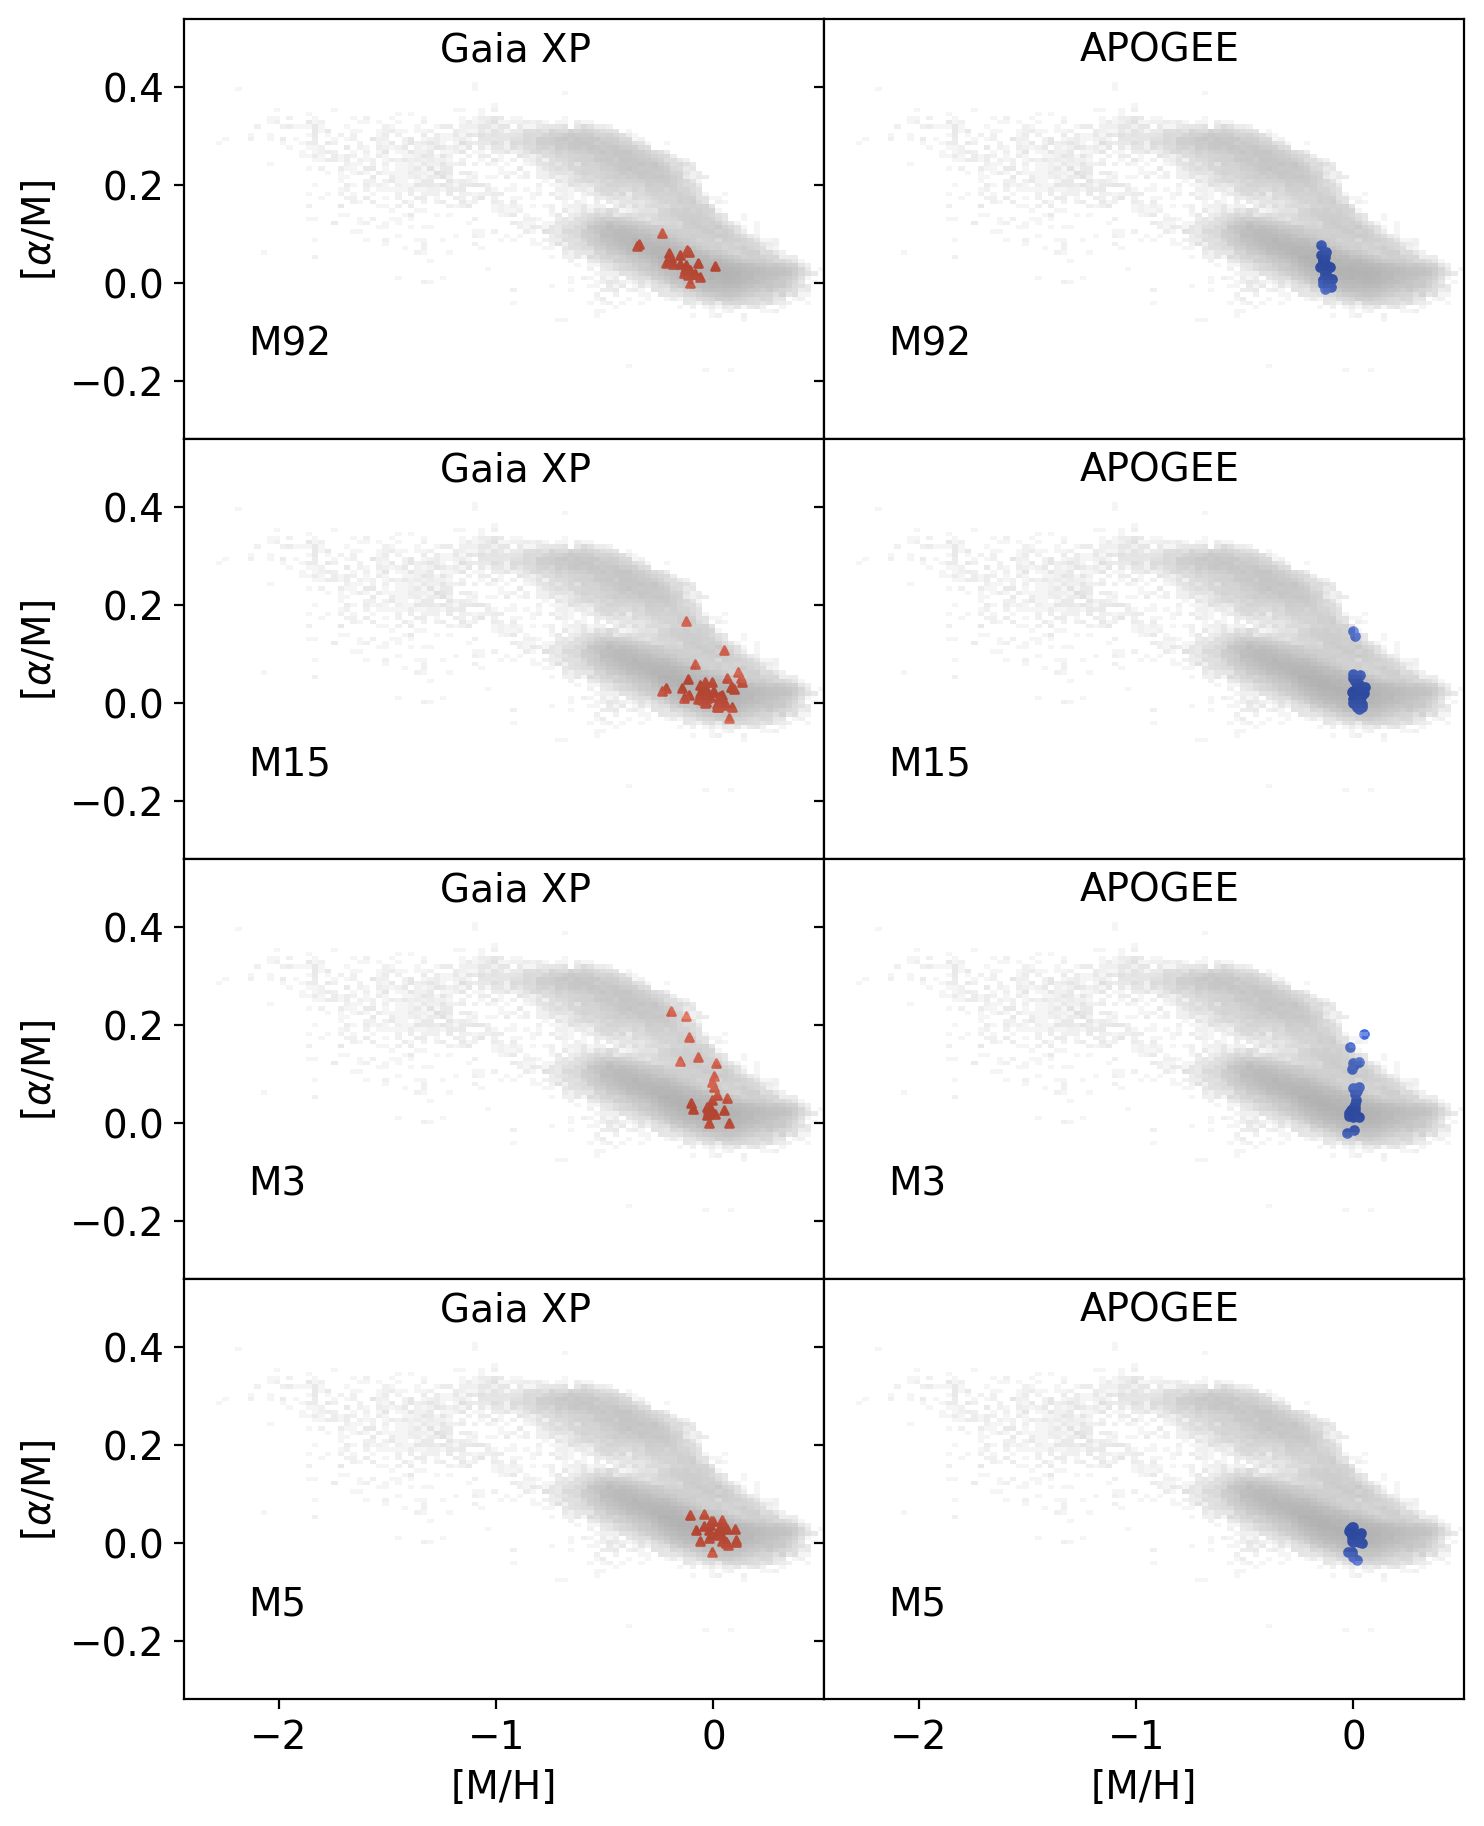

In [377]:
moh_range = [-2.5, 0.5]
aom_range = [-0.15, 0.45]


# aom_moh_diag = plt.imread("../fig/alpha_dia_bkg.png")

fig, axs = plt.subplots(len(cluster_names),2, figsize=(8, 2.5*len(cluster_names)), sharey=True, sharex=True)

for i, (gn,cluster) in enumerate(oc_grouped.groupby('CLUSTER')):

    ax1, ax2 = axs[i,:]
    ax1.scatter(cluster['moh_cross'], cluster['aom_cross'],
                s=8, c='tomato', marker='^')
    ax1.set_xlim(moh_range)
    ax1.set_ylim(aom_range)
    ax1.hist2d(rdf['M_H'], rdf['ALPHA_M'], bins=100, alpha=0.3,
           cmap='binary', norm=colors.LogNorm())
    ax1.text(0.1, 0.2, cluster_names[i], 
            transform=ax1.transAxes, zorder=3)
    ax1.text(0.4, 0.9, 'Gaia XP',
            transform=ax1.transAxes, zorder=3)
    ax1.set_xlabel('[M/H]'); ax1.set_ylabel(r'[$\alpha$/M]');
    
    ax2.scatter(cluster['M_H'], cluster['ALPHA_M'], 
                s=8, c='royalblue', marker='o')
    ax2.set_xlim(moh_range)
    ax2.set_ylim(aom_range)
    ax2.hist2d(rdf['M_H'], rdf['ALPHA_M'], bins=100, alpha=0.3,
           cmap='binary', norm=colors.LogNorm())
    ax2.text(0.1, 0.2, cluster_names[i],
            transform=ax2.transAxes, zorder=3)
    ax2.text(0.4, 0.9, 'APOGEE',
            transform=ax2.transAxes, zorder=3)
    ax2.set_xlabel('[M/H]'); 
    # ax2.set_ylabel(r'[$\alpha$/M]');

# plt.tight_layout()
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.99, wspace=0, hspace=0)
fig.savefig("../fig/oc_valid.pdf")